In [1]:
import numpy as np
import os

from qonnx.core.modelwrapper import ModelWrapper

from qonnx.custom_op.registry import getCustomOp

import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import finn.util.data_packing as dpk
from qonnx.core.datatype import DataType

In [2]:
from pathlib import Path
import cv2
# import my_metrics as metrics
import matplotlib.pyplot as plt

# Load Image and Label

In [3]:
def get_label(label_file):
    '''
    Receives a txt file and returns the label associated, as [smoke?, fire?]
    '''
    label_array = np.zeros((2))
    
    with open(label_file) as f:
        lines = f.readlines()
        for line in lines:
            class_id, _, _, _, _ = line.strip().split()
            class_id = int(class_id)
            if np.array_equal(label_array, np.array([1, 1])):
                break
            else:
                label_array[class_id] = 1.

    label_array = np.expand_dims(label_array, axis=0)

    return label_array    

In [4]:
def load_image_and_label(img_file, labels_dir):
    '''
    Receives image and label files and returns the image ready for FINN and corresponding label   
    '''
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (230, 230), interpolation = cv2.INTER_LINEAR)
    img = img.copy().astype(np.float32)    
    img = np.expand_dims(img, axis=0)

    img_name = Path(img_file).stem
    label_file = labels_dir + img_name + '.txt'
    label = get_label(label_file)

    return img, label

### Images and Labels Folders

In [5]:
DS_FOLDER = '../../datasets/dfire_mini/'
# DS_FOLDER += 'train/'
DS_FOLDER += 'test/'

DS_IMGS = DS_FOLDER + 'images/'
DS_LABELS = DS_FOLDER + 'labels/'

In [6]:
IMGS_LIST = sorted([DS_IMGS + img_file for img_file in os.listdir(DS_IMGS)])

In [7]:
print(IMGS_LIST[10])

../../datasets/dfire_mini/test/images/PublicDataset01212.jpg


### Little reshape test

In [8]:
# a = np.array([[[1, 2], [3, 4]]])
# print(a.shape)
# b = np.array([[[5, 6], [7, 8]]])
# print(a.shape)
# c = np.concatenate((a, b))
# print(c.shape)
# print(a)
# print(b)
# print(c)
# print(c.reshape(1, -1, 2))

### Load Test Image and Label

In [9]:
IMG_BATCH = True

### TRAIN
# test_img = IMGS_LIST[32] # Only Smoke
# test_img = IMGS_LIST[90] # Smoke & Fire
# test_img_list = [IMGS_LIST[2], IMGS_LIST[32], IMGS_LIST[90]]

### TEST
test_img_list = [IMGS_LIST[2], IMGS_LIST[9], IMGS_LIST[12], IMGS_LIST[14],
                 IMGS_LIST[18], IMGS_LIST[19], IMGS_LIST[24], IMGS_LIST[27]]

if not IMG_BATCH:
    npy_img, npy_label = load_image_and_label(
        img_file=test_img, 
        labels_dir=DS_LABELS)
else:
    npy_img, npy_label = load_image_and_label(
        img_file=test_img_list[0], 
        labels_dir=DS_LABELS)
    for i in range(len(test_img_list)):
        if i != 0:
            i_npy_img, i_npy_label = load_image_and_label(
                img_file=test_img_list[i], 
                labels_dir=DS_LABELS)
            npy_img = np.concatenate((npy_img, i_npy_img))
            npy_label = np.concatenate((npy_label, i_npy_label))    

In [10]:
print(f'Image shape = {npy_img.shape}')
print(f'Image data type = {npy_img.dtype}')

print(f'Label shape = {npy_label.shape}')
print(f'Label data type = {npy_img.dtype}')

Image shape = (8, 230, 230, 3)
Image data type = float32
Label shape = (8, 2)
Label data type = float32


### Plot Image

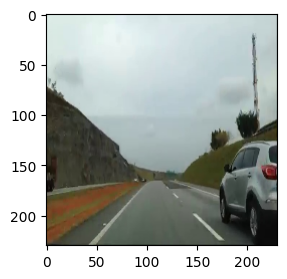

In [11]:
fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(npy_img[3]/255.)
plt.show()

### Print Some Pixels

In [12]:
# # print(npy_img[0, :3, :3, :])

# i = 4
# j = 4
# c = 3
# npy_img_list = npy_img[0, :4, :4, :].tolist()

# print(npy_img_list)
# for row in range(i):
#     for col in range(j):
#         rgb2print = []
#         for channel in range(c):
#             rgb2print = rgb2print + [hex(int(npy_img_list[row][col][channel]))]
#         print(rgb2print)
# # # plt.imshow(npy_img[0, :5, :5, :]/255.)
# # # plt.show()

### Template and Build folders

#### 750 FPS

In [13]:
# verilog_stitched_folder = './verilog_stitched_sim/750_FPS'
# template_folder = './verilog_stitched_sim/templates'
# build_folder = ('./experiments_bed_fpga_old_paper/NEW_SmallBig_Trained' 
#                + '/750_FPS'
#                + '/05_full_build_mvau_rtl_hls'
#                + '/output_full_build')

#### 30 FPS

In [14]:
# verilog_stitched_folder = './verilog_stitched_sim/30_FPS'
# template_folder = './verilog_stitched_sim/templates'
# build_folder = ('./experiments_bed_fpga_old_paper/NEW_SmallBig_Trained' 
#                + '/30_FPS_200us'
#                + '/04_full_build_mvau_rtl_hls'
#                + '/output_full_build')

#### 5 FPS

In [15]:
verilog_stitched_folder = './verilog_stitched_sim/05_FPS'
template_folder = './verilog_stitched_sim/templates'
build_folder = ('./experiments_bed_fpga_old_paper/NEW_SmallBig_Trained' 
               + '/05_FPS_1us'
               + '/02_full_build_mvau_rtl_hls'
               + '/output_full_build')

### Filenames

In [16]:
inp_fname = '/input_batch_8'
expected_oup_fname = '/expected_output_batch_8'

inp_npy_fname = inp_fname + '.npy'
expected_oup_npy_fname = expected_oup_fname + '.npy'

inp_dat_fname = inp_fname + '.dat'
expected_oup_dat_fname = expected_oup_fname + '.dat'

In [17]:
print(inp_npy_fname, "\n", expected_oup_npy_fname)
print(inp_dat_fname, "\n", expected_oup_dat_fname)

/input_batch_8.npy 
 /expected_output_batch_8.npy
/input_batch_8.dat 
 /expected_output_batch_8.dat


### Save Numpy files

In [18]:
np.save(verilog_stitched_folder + inp_npy_fname, npy_img)
np.save(verilog_stitched_folder + expected_oup_npy_fname, npy_label)

### Load Numpy files to check

In [19]:
inp_check = np.load(verilog_stitched_folder + inp_npy_fname)
oup_check = np.load(verilog_stitched_folder + expected_oup_npy_fname)

In [20]:
print(f'Input shape: {inp_check.shape}')
print(f'Input type: {inp_check.dtype}')

print(oup_check.shape)

Input shape: (8, 230, 230, 3)
Input type: float32
(8, 2)


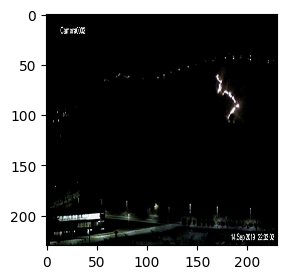

In [21]:
fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(inp_check[0]/255.)
plt.show()

# Manual Checkings

### Image data to input.dat

In [22]:
# Model and Stitched folder
model_filename = build_folder + "/intermediate_models/step_create_stitched_ip.onnx"
model = ModelWrapper(model_filename)

# load the provided input data
inp_data = np.load(verilog_stitched_folder + inp_npy_fname)
batchsize = inp_data.shape[0]
print(f'Batch size: {batchsize}')

Batch size: 8


In [23]:
# permute input image from NCHW -> NHWC format (needed by FINN)
# No need to do this, as images will be loaded from cv2 as (N, H, W, C) -> (1, 224, 224, 3)
# inp_data = np.transpose(inp_data, (0, 2, 3, 1))

# ??? Intended for flattened FC networks... just to try. Not needed here.
#inp_data = inp_data.reshape(batchsize, -1)
#print(f'Input data flattened: {inp_data}')

In [24]:
# query the parallelism-dependent folded input shape from the
# node consuming the graph input
inp_name = model.graph.input[0].name
inp_node = getCustomOp(model.find_consumer(inp_name))
inp_shape_folded = list(inp_node.get_folded_input_shape())

print(f'Input shape folded: {inp_shape_folded}')

inp_stream_width = inp_node.get_instream_width_padded()

print(f'Input stream width: {inp_stream_width}')

Input shape folded: [1, 230, 230, 3, 1]
Input stream width: 8


In [25]:
# # fix first dimension (N: batch size) to correspond to input data
# # since FINN model itself always uses N=1
inp_shape_folded[0] = batchsize
inp_shape_folded = tuple(inp_shape_folded)
inp_dtype = model.get_tensor_datatype(inp_name)
print(f'Input data type: {inp_dtype}')
# now re-shape input data into the folded shape and do hex packing
inp_data = inp_data.reshape(inp_shape_folded)

print(f'Input data after folded reshape: {inp_data.shape}')

Input data type: UINT8
Input data after folded reshape: (8, 230, 230, 3, 1)


In [26]:
inp_data_packed = dpk.pack_innermost_dim_as_hex_string(
    inp_data, inp_dtype, inp_stream_width, prefix="", reverse_inner=True
)

print(f'Input data packed: {inp_data_packed.shape}')
# print(inp_data_packed)

Input data packed: (8, 230, 230, 3)


In [27]:
# # np.savetxt cannot save arrays of more than 2D
# # data packed is 4D (1, 224, 224, 3)
# # First Fifo has PE=1 -> 1 element at a time, of size 8
if not IMG_BATCH:
    inp_data_packed = np.squeeze(inp_data_packed)
    print(f'Input data packed after squeeze: {inp_data_packed.shape}')
else:
    inp_data_packed = np.reshape(inp_data_packed, (1, -1, inp_data_packed.shape[2]))  
    inp_data_packed = np.squeeze(inp_data_packed)
    print(f'Input data packed after reshape: {inp_data_packed.shape}')

np.savetxt(verilog_stitched_folder + inp_dat_fname, inp_data_packed, fmt="%s", delimiter="\n")

Input data packed after reshape: (5520, 230)


### Label to out.dat

In [28]:
# load expected output and calculate folded shape
exp_out = np.load(verilog_stitched_folder + expected_oup_npy_fname)    
out_name = model.graph.output[0].name
out_node = getCustomOp(model.find_producer(out_name))
out_shape_folded = list(out_node.get_folded_output_shape())
out_stream_width = out_node.get_outstream_width_padded()
print(f'Out stream width: {out_stream_width}')
out_shape_folded[0] = batchsize
out_shape_folded = tuple(out_shape_folded)
print(f'Out shape folded: {out_shape_folded}')
out_dtype = model.get_tensor_datatype(out_name)
print(f'Out data type: {out_dtype}')
exp_out = exp_out.reshape(out_shape_folded)
out_data_packed = dpk.pack_innermost_dim_as_hex_string(
    exp_out, out_dtype, out_stream_width, prefix="", reverse_inner=True
)
np.savetxt(
    verilog_stitched_folder + expected_oup_dat_fname,
    out_data_packed,
    fmt="%s",
    delimiter="\n",
)

Out stream width: 8
Out shape folded: (8, 2, 1)
Out data type: BINARY


### Testbench file

In [29]:
# fill in testbench template
with open(template_folder + "/finn_testbench.template.sv", "r") as f:
    testbench_sv = f.read()
testbench_sv = testbench_sv.replace("@N_SAMPLES@", str(batchsize))
testbench_sv = testbench_sv.replace("@IN_STREAM_BITWIDTH@", str(inp_stream_width))
testbench_sv = testbench_sv.replace("@OUT_STREAM_BITWIDTH@", str(out_stream_width))
testbench_sv = testbench_sv.replace(
    "@IN_BEATS_PER_SAMPLE@", str(int(np.prod(inp_shape_folded[:-1]) / batchsize))
)
testbench_sv = testbench_sv.replace(
    "@OUT_BEATS_PER_SAMPLE@", str(int(np.prod(out_shape_folded[:-1]) / batchsize))
)
#testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", "1000")
# testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", "11710954") # Taken from eval_stitched_ip

time_out = 1600000 # 200000*8, 200k is the latency of first picture; 8 images in the batch
if not IMG_BATCH:
    time_out_str = str(time_out) 
    testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", time_out_str) # A little bit more than latency
else:
    time_out_str = str(batchsize * time_out) 
    testbench_sv = testbench_sv.replace("@TIMEOUT_CYCLES@", time_out_str) # A little bit more than latency
    
if not IMG_BATCH:
    with open(verilog_stitched_folder + "/finn_testbench.sv", "w") as f:
        f.write(testbench_sv)
else:
    with open(verilog_stitched_folder + "/finn_testbench_batch.sv", "w") as f:
        f.write(testbench_sv)